In [15]:
import os
import json
from pathlib import Path

import numpy as np
import pandas as pd

import faiss
import torch
import torch.nn as nn

import wandb
import pytorch_metric_learning

In [3]:
data_dir = Path("/data/")
data_dir.exists()

True

In [41]:
datasets = {
    "footy" : "s3://aisle3-ml-datasets/footy/main.parquet",
    "solesupplier" : "s3://aisle3-ml-datasets/solesupplier/main.parquet",
}

for source, data_path in datasets.items():
    print(source, data_path)
    df = pd.read_parquet(data_path)
    df["merchant"] = source
    df["id"] = df.merchant + "." + df.id
    df.image = df.image.str.replace("s3://", "")
    print(df.shape)
    datasets[source] = df

footy s3://aisle3-ml-datasets/footy/main.parquet
(59085, 14)
solesupplier s3://aisle3-ml-datasets/solesupplier/main.parquet
(84893, 9)


In [47]:
df = pd.read_parquet("s3://aisle3-ml-datasets/product-matching/aisle3/deduped.parquet")
df.image = df.image.str.replace("s3://", "") + ".jpg"
df

,id,variant_id,title,merchant,brand,gender,color,imid,image_url,image,pose,phash,md5,label
0,allsole.10491511,allsole.10491633,Vans Authentic Canvas Trainers,allsole,vans,unisex,Black,26789,https://aisle-3-image-final.s3.eu-west-2.amazo...,aisle-3-image-final/images/original/allsole/al...,side_shot,aff00c80ffd01b337b006ccde-aff40c80ffd01a337b00...,22e646989821796152307bef73fbc568,0
1,allsole.10491511,allsole.10491633,Vans Authentic Canvas Trainers,allsole,vans,unisex,Black,26790,https://aisle-3-image-final.s3.eu-west-2.amazo...,aisle-3-image-final/images/original/allsole/al...,side_shot,fea15c98da845223fb91e446e-f6a15c98fa845223fb99...,2875924f6d79dd99bc669cdbe84d82c7,0
2,allsole.10491511,allsole.10491633,Vans Authentic Canvas Trainers,allsole,vans,unisex,Black,26791,https://aisle-3-image-final.s3.eu-west-2.amazo...,aisle-3-image-final/images/original/allsole/al...,side_shot,aba51ec0e7931a89d54a6fa15-aba51ec0e7931a89d54a...,5da5243580c580f0cce4bfd54f6dd35a,0
3,allsole.10491511,allsole.10491633,Vans Authentic Canvas Trainers,allsole,vans,unisex,Black,26792,https://aisle-3-image-final.s3.eu-west-2.amazo...,aisle-3-image-final/images/original/allsole/al...,upper_shot,e7a66ce0e29c599987399a499-e7a66c60e69c59998739...,f28aae91e89aa1de723d993580253b61,0
4,allsole.10491511,allsole.10491633,Vans Authentic Canvas Trainers,allsole,vans,unisex,Black,26793,https://aisle-3-image-final.s3.eu-west-2.amazo...,aisle-3-image-final/images/original/allsole/al...,partial_shot,bc8d2d0f0f4b73c9d128d24e5-bc8d0c0f2f4b71c9d1a8...,393a50c1c362a7189130a944ee897f73,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200738,ssense.221903M237021,ssense.221903M237021,Coach 1941 Black & Off-White Logo Slide Sandals,ssense,coach,men,Chalk black,95785,https://aisle-3-image-final.s3.eu-west-2.amazo...,aisle-3-image-final/images/original/ssense/sse...,partial_shot,baf905ac67e514ba9542c00ff-baf905ac67e514ba9542...,fd39a5006695521400f9849a3aeb67de,45263
200739,ssense.221903M237021,ssense.221903M237021,Coach 1941 Black & Off-White Logo Slide Sandals,ssense,coach,men,Chalk black,95786,https://aisle-3-image-final.s3.eu-west-2.amazo...,aisle-3-image-final/images/original/ssense/sse...,pair_shot,ffe007805ec5ca7b805ec45e6-ffe007805ec5ca7b805e...,7cf2113b8e0c1710499bddd7df584fe3,45263
200740,ssense.221903M237021,ssense.221903M237021,Coach 1941 Black & Off-White Logo Slide Sandals,ssense,coach,men,Chalk black,95787,https://aisle-3-image-final.s3.eu-west-2.amazo...,aisle-3-image-final/images/original/ssense/sse...,side_shot,eeac14fb32b053ef8217d21a2-eeac54fb32b053ef8017...,f8553fbe9f45b50038b60cd6583af1a3,45263
200741,ssense.221903M237021,ssense.221903M237021,Coach 1941 Black & Off-White Logo Slide Sandals,ssense,coach,men,Chalk black,95788,https://aisle-3-image-final.s3.eu-west-2.amazo...,aisle-3-image-final/images/original/ssense/sse...,pair_shot,ffaa46cb15804f2ccb1dc20de-ffaa46ca15804f2ccb1d...,7ad47c5d9bacfa208d68545964717006,45263


In [48]:
df = pd.concat([df, *datasets.values()], axis=0, ignore_index=True)[["id", "merchant", "brand", "gender", "image"]]
df

,id,merchant,brand,gender,image
0,allsole.10491511,allsole,vans,unisex,aisle-3-image-final/images/original/allsole/al...
1,allsole.10491511,allsole,vans,unisex,aisle-3-image-final/images/original/allsole/al...
2,allsole.10491511,allsole,vans,unisex,aisle-3-image-final/images/original/allsole/al...
3,allsole.10491511,allsole,vans,unisex,aisle-3-image-final/images/original/allsole/al...
4,allsole.10491511,allsole,vans,unisex,aisle-3-image-final/images/original/allsole/al...
...,...,...,...,...,...
344716,solesupplier.fffe27efefbad0baf374beb5ea1398e6,solesupplier,Nike,NaN,aisle3-ml-datasets/solesupplier/images/fffe27e...
344717,solesupplier.fffe27efefbad0baf374beb5ea1398e6,solesupplier,Nike,NaN,aisle3-ml-datasets/solesupplier/images/fffe27e...
344718,solesupplier.fffe27efefbad0baf374beb5ea1398e6,solesupplier,Nike,NaN,aisle3-ml-datasets/solesupplier/images/fffe27e...
344719,solesupplier.fffe27efefbad0baf374beb5ea1398e6,solesupplier,Nike,NaN,aisle3-ml-datasets/solesupplier/images/fffe27e...


In [53]:
(data_dir / df.image).apply(os.path.isfile).value_counts()

True    344721
Name: image, dtype: int64

<AxesSubplot:>

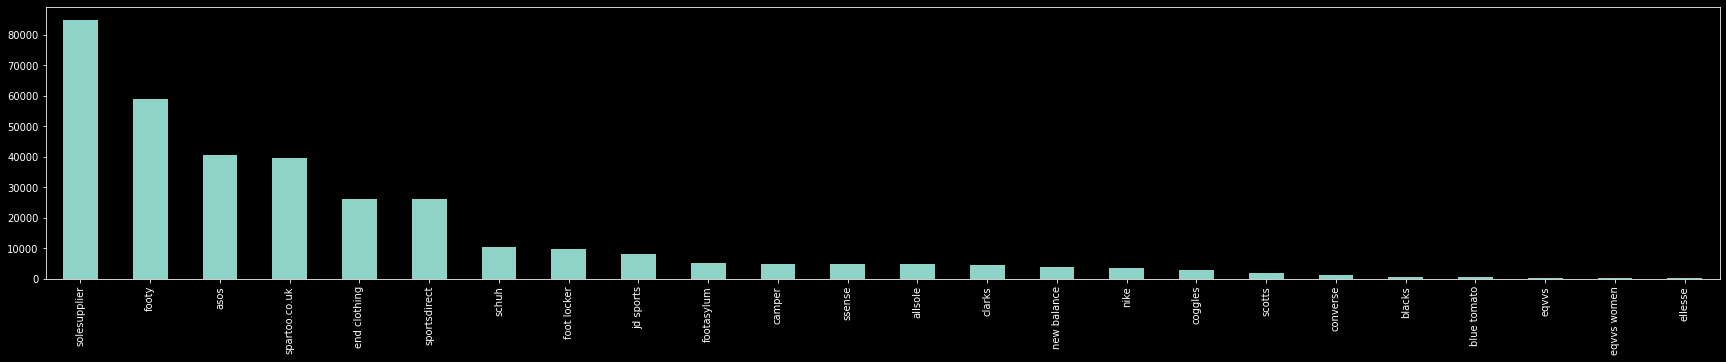

In [54]:
df.merchant.value_counts().plot.bar(figsize=(30, 5))

<AxesSubplot:>

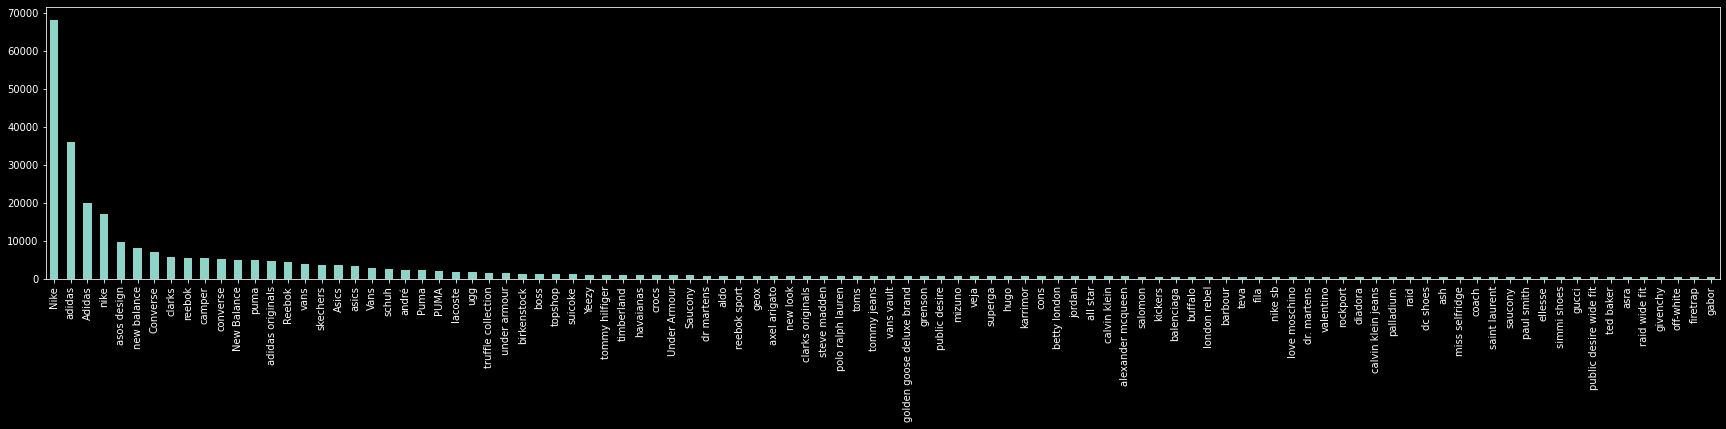

In [55]:
df.brand.value_counts().head(100).plot.bar(figsize=(30, 5))

In [ ]:
import cv2
from PIL import Image
import albumentations as A
from torchvision import transforms as T
from torch.utils.data import Dataset
from typing import Union
from loguru import logger


class ImageDataset(Dataset):
    def __init__(
        self,
        df: pd.DataFrame,
        image_col: str = "image",
        label_col: str = None,
        data_dir="./data/",
        backend: str = "pil",
        transform: Union[T.Compose, A.Compose, None] = None,
        alpha_fill: int = 255,
    ):
        """
        Pytorch dataset class for Images
        Expects a dataframe containing an {image_col} column with the image file names.

        Parameters:
            df: pandas dataframe containing the image file names
            image_col: name of the column containing the image file names
            label_col: name of the column containing the labels
            data_dir: directory where the images are stored
            backend (str): backend to use for reading the images [cv2, pil].
            transform: albumentations or torchvision transforms to apply to the images
        """
        super().__init__()
        self.df = df
        self.image_col = image_col
        self.label_col = label_col
        self.data_dir = data_dir

        self.backend = backend
        self.alpha_fill = alpha_fill
        assert self.backend in ["cv2", "pil"]
        logger.info(f"Transform: \n{repr(transform)}")
        logger.info(f"Image I/O Backend: {self.backend}")
        if transform is not None:
            if isinstance(transform, A.Compose):
                self.transform = lambda img: transform(image=np.asarray(img))["image"]
            elif isinstance(transform, T.Compose):
                self.transform = transform
                self.backend = "pil"
            else:
                raise ValueError(
                    f"{transform} should be either albumentations or torchvision.transforms"
                )
        else:
            self.transform = None

    def read_cv2_image(self, fimg: str):
        img = cv2.imread(fimg, -1)
        if img.shape[-1] == 4:
            mask = img[:, :, 3] == 0
            img[mask] = [self.alpha_fill] * 4
        return cv2.cvtColor(cv2.imread(fimg), cv2.COLOR_BGR2RGB)

    def read_pil_image(self, fimg: str):
        with open(fimg, "rb") as f:
            return Image.open(f).convert("RGB")

    def read_image(self, fimg: str):
        fimg = os.path.join(self.data_dir, fimg)
        if self.backend == "cv2":
            return self.read_cv2_image(fimg)
        elif self.backend == "pil":
            return self.read_pil_image(fimg)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        fimg = self.df.at[idx, self.image_col]
        img = self.read_image(fimg)

        if self.transform is not None:
            img = self.transform(img)

        if self.label_col:
            label = self.df.at[idx, self.label_col]
            return img, label
        return img

